In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML
from os import listdir

PATH = r'D:\Code\kural_work\movie_generation\data\\'
crop_img_tensor = torch.load(PATH+'crop_img_tensor.variable')

In [33]:
all_files = os.listdir(PATH)
all_tifs = []
for file in all_files:
    if file[-13:] != 'crop_data.pkl': continue
    all_tifs.append(file)

In [34]:
all_tifs

['as02_10m_2s_100ms_25p_crop_data.pkl',
 'as03_30m_2s_50ms_100p_crop_data.pkl',
 'as04_15m_1s_50ms_100p_crop_data.pkl',
 'as05_15m_1s_50ms_100p_crop_data.pkl',
 'as06_15m_1s_50ms_100p_crop_data.pkl',
 'as07_15m_1s_50ms_100p_crop_data.pkl',
 's01_5m_2s_100ms_25p_crop_data.pkl',
 's02_39m_4s_50ms_100p_crop_data.pkl',
 's03_10m_2s_100ms_25p_crop_data.pkl',
 's04_32m_4s_50ms_100p_crop_data.pkl',
 's05_70m_4s_50ms_100p_crop_data.pkl',
 's07_15m_1s_50ms_100p_crop_data.pkl',
 's08_30m_2s_50ms_100p_crop_data.pkl']

In [35]:
tifs = []
for i,file in enumerate(all_tifs):
    if '_4s_' in file:
        print(i)
        continue
    tifs.append(file)

7
9
10


In [37]:
tmp_tensor = crop_img_tensor[:4949]

In [38]:
tmp_tensor = torch.cat((tmp_tensor,crop_img_tensor[5527:5828]))

In [39]:
tmp_tensor = torch.cat((tmp_tensor,crop_img_tensor[7324:]))

In [40]:
tmp_tensor.shape

torch.Size([7052, 1, 128, 128])

In [41]:
tifs = [tifs[i][:-14] + '.tif' for i in range(len(tifs))]

In [42]:
nf_list = []
for tif in tifs:
    img_ = Image.open(PATH+tif)
    nf_list.append(img_.n_frames)
nf = np.stack(nf_list)
nf = np.cumsum(nf)
print(nf)

[ 301 1202 2103 3004 3905 4806 4949 5250 6151 7052]


In [43]:
tensor_so_far = tmp_tensor.clone().detach()
nf_so_far = nf.copy()

In [44]:
nf = np.concatenate(([0],nf))
movies = [tmp_tensor[nf[i]:nf[i+1]] for i in range(len(nf)-1)]

In [45]:
ones = []
for i,file in enumerate(tifs):
    if '_1s_' in file:
        ones.append(i)

In [46]:
split_movies = []
for i, movie in enumerate(movies):
    if i in ones:
        split_movies.extend((movie[::2],movie[1::2]))
    else:
        split_movies.append(movie)

In [49]:
nf = np.cumsum(np.array([split_movies[i].shape[0] for i in range(len(split_movies))]));nf

array([ 301, 1202, 1653, 2103, 2554, 3004, 3455, 3905, 4356, 4806, 4949, 5250, 5701, 6151, 7052], dtype=int32)

In [50]:
split_crop_img_tensor = torch.cat(split_movies)

In [86]:
with open(PATH+'split_crop_img_tensor_and_nf.pickle','wb') as f:
    pickle.dump((split_crop_img_tensor,nf),f)  

In [2]:
with open(PATH+'split_crop_img_tensor_and_nf.pickle','rb') as f:
    split_crop_img_tensor, nf = pickle.load(f)

In [51]:
class test():
    def __init__(self):
        self.tmp = 4
    out_tmp1 = 3
    def tmp1(self, input):
        return input
    func = {0:tmp1}
    def tmp2(self):
        return self.func[0](self, -1)

In [52]:
t = test()

In [53]:
t.tmp2()

-1

In [14]:
for i in range(8):
    a = [0,0,0]
    for j in range(3):
        if (i//2**j)%2 == 1:
            a[2-j] = 1
    print(a)

[0, 0, 0]
[0, 0, 1]
[0, 1, 0]
[0, 1, 1]
[1, 0, 0]
[1, 0, 1]
[1, 1, 0]
[1, 1, 1]


In [3]:
split_crop_img_tensorimg_tensor.shape

torch.Size([7052, 1, 128, 128])

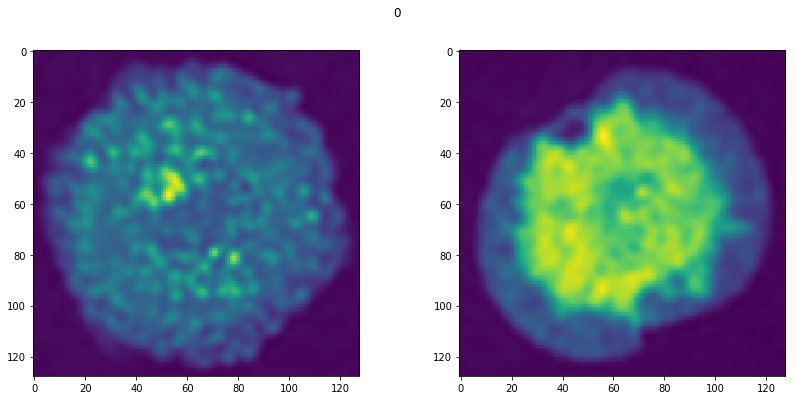

In [72]:
if i>=len(nf)-1: i=0
fig, ax = plt.subplots(1,2,figsize=[14,6])
ax[0].imshow(split_crop_img_tensor[nf[i]-1,0])
ax[1].imshow(split_crop_img_tensor[nf[i],0])
plt.suptitle(str(i))
plt.show()
i+=1

In [6]:
em_model = ConvolutionalAutoencoderModel()
em_model.load_state_dict(torch.load('C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\convolutional_autoencoder_model.pth'))
em_model.eval()
em_model = em_model.cuda()

In [60]:
ds = FutureImageDataset(split_crop_img_tensor,nf,8,150)
embeddedMovies = torch.zeros((len(ds)*ds.nt,ds.input+1,128))
for i in range(len(ds)):
    out_list = ds[i]
    for sequence, future in out_list:
        embeddedMovies[i,:ds.input] = em_model.convolution(sequence.cuda()).data.cpu().view(-1,128)
        embeddedMovies[i,-1] = em_model.convolution(future.cuda()).data.cpu().view(128)

embeddedMovies.transpose_(1,2);

In [61]:
with open(PATH+'splitEmbeddedMovies_5m.pickle','wb') as f:
    pickle.dump(embeddedMovies,f)  

In [7]:
with open(PATH+'splitEmbeddedMovies_5m.pickle','rb') as f:
    embeddedMovies = pickle.load(f)

In [62]:
(nf-np.cumsum((8+150-1)*np.ones_like(nf)))*8

array([ 1152,  7104,  9456, 11800, 14152, 16496, 18848, 21192, 23544, 25888, 25776, 26928, 29280, 31624,
       37576])

In [8]:
holdout_movies = embeddedMovies[31624:].clone().detach()
train_movies = embeddedMovies[:31624].clone().detach()

In [9]:
?? torch.utils.data.TensorDataset

In [33]:
ds = EmbeddedFutureImageDataset(train_movies)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 100
clip = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True),drop_last=True)
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx),drop_last=True)
model = FuturePrediction1DConvModel().cuda()
lr_start = 3e-3
opt = optim.Adam(model.parameters(),lr=lr_start)
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [36]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start, lr_end=1e-5, epochs=100, cycles=10)

restart number 1 out of 1
Spent 205m 18s doing 1000 total steps for an average of 12.3s per step.


In [32]:
%debug

> <ipython-input-25-2805957e443f>(1)<module>()
----> 1 model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start)

ipdb> in
*** SyntaxError: invalid syntax
ipdb> quit(


In [154]:
# @do_profile(follow=[])
# def profile_fit():
restarts = 1
# lr_start = 3e-3
lr_end = 1e-5
# lr_end = lr_start
for restart in range(restarts):
    cycles = 3
    epochs = 100
    print(f'restart number {restart+1} out of {restarts}')
#     if len(train_loss)>0: opt = optim.SGD(model.parameters(),lr=lr_start,momentum=0.9)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
#         if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.99)
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
            opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(cycle/cycles*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data, in train_dl:
                x_train = data.cuda()
                opt.zero_grad()
                y_pred = model(x_train[:,:,:-1])
                loss = criterion(y_pred,x_train[:,:,-1])
                loss.backward()
                _ = torch.nn.utils.clip_grad_norm_(model.conv.parameters(), clip)
                _ = torch.nn.utils.clip_grad_norm_(model.lin.parameters(), clip)
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data, in val_dl:
                    x_val = data.cuda()
                    y_pred = model(x_val[:,:,:-1])
                    running_loss += criterion(y_pred,x_val[:,:,-1]).item()
                val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
                epoch_time = (epochs-(epoch+1))*np.mean(epoch_time_list)
                epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in epoch: {int(epoch_time//3600)}h{int(epoch_time//60)-60*int(epoch_time//3600)}m{epoch_time%60:02.0f}s'
                print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1)-1)*np.mean(time_list)
        cycle_print_str = f'Finished cycle {cycle+1:3d}/{cycles} ~ Remaining after current cycle: {int(remaining_time//3600)}h{int(remaining_time//60)-60*int(remaining_time//3600)}m{remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')
        
#         return (train_loss, val_loss)

# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\kMeans_autoencoder_model.pth')
                                       

restart number 1 out of 1
Spent 7m 28s doing 300 total steps for an average of 1.5s per step.


In [181]:
tmp = next(iter(model.children()))

In [379]:
for child in model.children():
    print(id(child.parameters()))

2605467476568
2605467476568


In [380]:
id(model.conv.parameters())

2605467476304

In [43]:
train_loss = _tl
val_loss = _vl

In [58]:
_tl[-1]

[0.21324278485207332,
 0.2920958589585054,
 0.29196576005409636,
 0.29234366450044846,
 0.29181066663965344,
 0.2914288623465432,
 0.2922609480068324,
 0.29224808886647224,
 0.2919066483894038,
 0.2916109549206874,
 0.291735288879228,
 0.2921073570965774,
 0.29230346134494223,
 0.2915229183577356,
 0.29215201753236,
 0.2921042562358909,
 0.29226023621029323,
 0.29229124020489433,
 0.2915775338335643,
 0.2923208203107592,
 0.29613785067247966,
 0.29234802456838743,
 0.2920465109840272,
 0.29186166036460137,
 0.3016777348423761,
 0.29213450686444364,
 0.292370893356819,
 0.29233461024150964,
 0.2916763580980755,
 0.2915752528324014,
 0.29198093996161506,
 0.2919570902096374,
 0.29226318315144567,
 0.29185987098349464,
 0.29168815357935807,
 0.2921978770976975,
 0.2918671861823116,
 0.2923651449086647,
 0.29176349219466957,
 0.2921238893731719,
 0.2919207690135827,
 0.2918336857997236,
 0.29174814822654876,
 0.29255951036299976,
 0.29201941156671163,
 0.29168357232969905,
 0.2919616967971

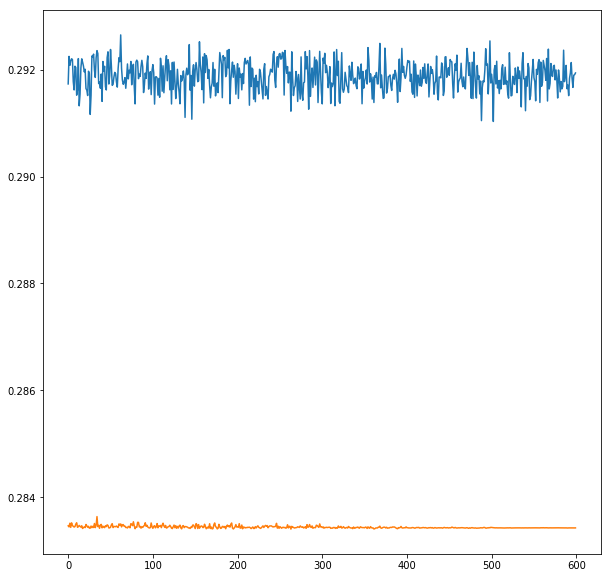

In [61]:
slc = slice(400,len(train_loss)-1)
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.show()

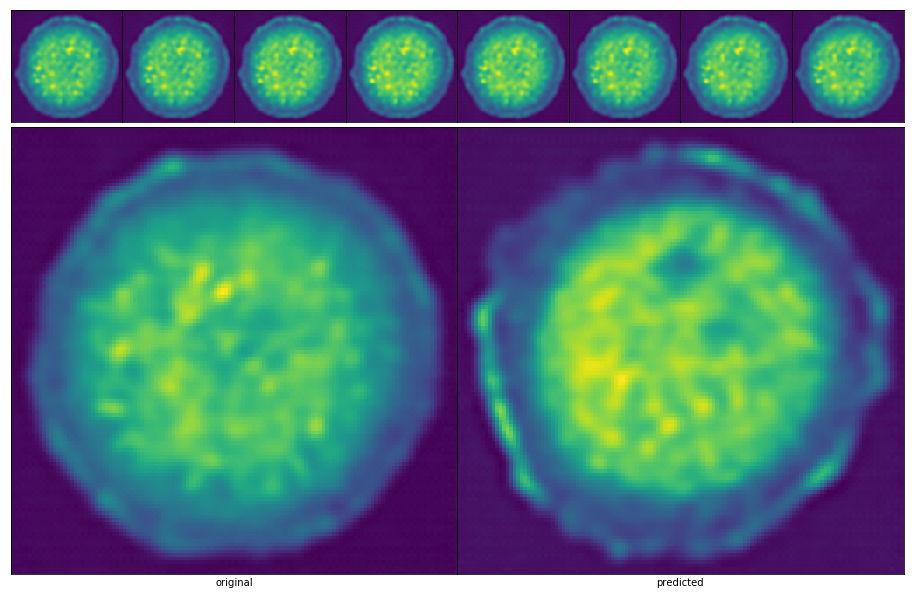

In [161]:
model.eval()
holdout_ds = torch.utils.data.TensorDataset(holdout_movies)
plt.figure(figsize=[16,10])
gs = gridspec.GridSpec(2,8,height_ratios=[1,4],wspace=0,hspace=0,bottom=0,top=.79)
ax = []
for i in range(8):
    ax.append(plt.subplot(gs[0,i]))
ax.append(plt.subplot(gs[1,:4]))
ax.append(plt.subplot(gs[1,4:]))
idx = np.random.choice(len(holdout_ds))
data, = holdout_ds[idx]
for i in range(9):
    img = em_model.deconvolution(data[:,i].view(1,128,1,1).cuda()).data.cpu()
    ax[i].imshow(img.squeeze())
y_pred = model(data[None,:,:-1].cuda())
img =  em_model.deconvolution(y_pred.view(1,128,1,1)).data.cpu()
ax[-1].imshow(img.squeeze())
for i in range(len(ax)):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[-2].set_xlabel('original')
ax[-1].set_xlabel('predicted')
plt.show()

In [133]:
data.shape

torch.Size([128, 9])